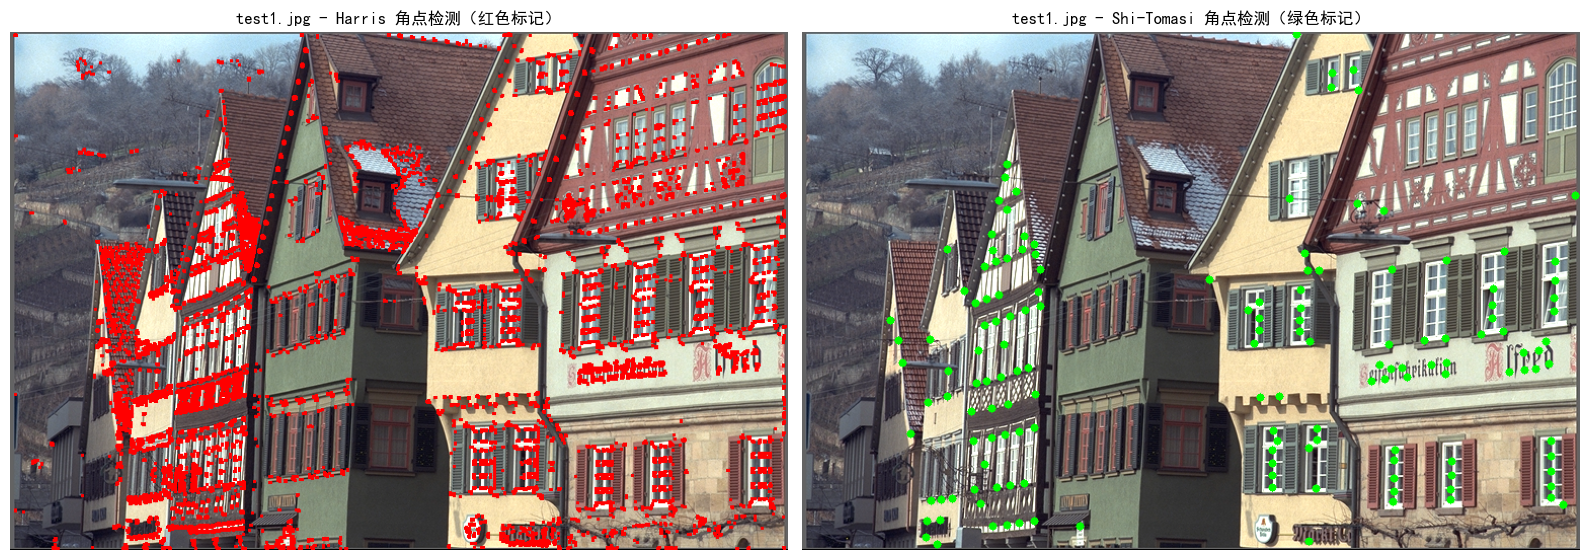

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------------- 1. 准备测试图像（统一使用 test1.jpg）----------------------
def get_test_image():
    img = cv2.imread("test2.jpg")

    # 读取失败时，生成备用人工棋盘格图（防止程序报错）
    if img is None:
        print("提示：未找到，自动生成备用人工角点图")
        img = np.ones((400, 400, 3), dtype=np.uint8) * 255
        grid_step = 80
        for i in range(0, 401, grid_step):
            cv2.line(img, (i, 0), (i, 400), (0, 0, 0), 2)
            cv2.line(img, (0, i), (400, i), (0, 0, 0), 2)

    return img

# 获取统一测试图像
test_img = get_test_image()
# 转为灰度图（两种算法均需要灰度输入）
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# ---------------------- 2. 定义两种角点检测函数（统一参数风格）----------------------
def harris_corner_detect(img, gray, block_size=2, ksize=3, k=0.04, threshold=0.01):
    """
    Harris 角点检测（封装 OpenCV 接口，统一输出格式）
    """
    # 转换为 32 位浮点型（Harris 要求输入格式）
    gray_float = np.float32(gray)

    # 调用 Harris 角点检测
    harris_dst = cv2.cornerHarris(gray_float, blockSize=block_size, ksize=ksize, k=k)

    # 膨胀结果（增强角点显示效果，非必需）
    harris_dst = cv2.dilate(harris_dst, None)

    # 复制原始图像用于绘制角点
    img_harris = img.copy()
    # 标记角点（红色：BGR 格式 (0, 0, 255)）
    img_harris[harris_dst > threshold * harris_dst.max()] = (0, 0, 255)

    return img_harris, harris_dst

def shi_tomasi_corner_detect(img, gray, max_corners=150, quality_level=0.01, min_distance=10):
    """
    Shi-Tomasi 角点检测（封装 OpenCV 接口，统一输出格式）
    """
    # 调用 Shi-Tomasi 角点检测（OpenCV 官方接口：goodFeaturesToTrack）
    corners = cv2.goodFeaturesToTrack(
        gray,
        maxCorners=max_corners,       # 最大检测角点数量
        qualityLevel=quality_level,   # 角点质量阈值（0~1，仅保留高于该值的角点）
        minDistance=min_distance,     # 角点之间的最小欧氏距离
        useHarrisDetector=False       # 禁用 Harris 检测，使用纯 Shi-Tomasi 算法
    )

    # 复制原始图像用于绘制角点
    img_shi_tomasi = img.copy()
    # 绘制角点（绿色：BGR 格式 (0, 255, 0)，圆形标记）
    if corners is not None:
        # 兼容新版本 NumPy，转换为整数坐标
        corners = np.int64(corners)
        for corner in corners:
            x, y = corner.ravel()
            cv2.circle(img_shi_tomasi, (x, y), 4, (0, 255, 0), -1)  # 实心圆标记

    return img_shi_tomasi, corners

# ---------------------- 3. 执行两种算法（统一参数，保证对比公平性）----------------------
# 对 test1.jpg 执行两种角点检测
test_harris, _ = harris_corner_detect(test_img, test_gray)
test_shi_tomasi, _ = shi_tomasi_corner_detect(test_img, test_gray)

# ---------------------- 4. 可视化对比结果（单图双算法，清晰直观）----------------------
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 支持中文标注
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 子图1：Harris 检测结果
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_harris, cv2.COLOR_BGR2RGB))
plt.title("test1.jpg - Harris 角点检测（红色标记）")
plt.axis("off")

# 子图2：Shi-Tomasi 检测结果
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_shi_tomasi, cv2.COLOR_BGR2RGB))
plt.title("test1.jpg - Shi-Tomasi 角点检测（绿色标记）")
plt.axis("off")

# 调整子图间距，避免重叠
plt.tight_layout()
plt.show()